# Anomalies Extraction Functions

In [ ]:
def eeg_band_anomaly_detector(eeg_df,
                                    sampling_rate=256,
                                    window_sec=2,
                                    alpha_thresh=0.2,
                                    beta_thresh=0.15,
                                    z_thresh=-2.0):
    from scipy.signal import welch
    from scipy.stats import zscore
    import numpy as np

    if 'Timestamp' not in eeg_df.columns:
        raise ValueError("Expected 'Timestamp' column in EEG data.")

    eeg_channels = eeg_df.select_dtypes(include=['number']).columns.difference(['Timestamp'])
    window_size = int(sampling_rate * window_sec)
    total_samples = len(eeg_df)
    num_windows = total_samples // window_size

    band_powers = {ch: {'theta': [], 'alpha': [], 'beta': []} for ch in eeg_channels}
    window_times = []

    for w in range(num_windows):
        start = w * window_size
        end = start + window_size
        seg = eeg_df.iloc[start:end]
        if len(seg) < window_size:
            continue

        window_times.append(seg['Timestamp'].mean())
        for ch in eeg_channels:
            freqs, psd = welch(seg[ch], fs=sampling_rate, nperseg=window_size)
            theta = np.trapezoid(psd[(freqs >= 4) & (freqs < 8)], freqs[(freqs >= 4) & (freqs < 8)])
            alpha = np.trapezoid(psd[(freqs >= 8) & (freqs < 12)], freqs[(freqs >= 8) & (freqs < 12)])
            beta = np.trapezoid(psd[(freqs >= 13) & (freqs < 30)], freqs[(freqs >= 13) & (freqs < 30)])

            band_powers[ch]['theta'].append(theta)
            band_powers[ch]['alpha'].append(alpha)
            band_powers[ch]['beta'].append(beta)

    anomalies = []

    # Local band ratio suppression
    alpha_ratios, beta_ratios = [], []
    for ch in eeg_channels:
        for i, t in enumerate(window_times):
            th = band_powers[ch]['theta'][i]
            al = band_powers[ch]['alpha'][i]
            be = band_powers[ch]['beta'][i]
            total = th + al + be
            if total == 0:
                continue
            alpha_ratio = al / total
            beta_ratio = be / total
            alpha_ratios.append(alpha_ratio)
            beta_ratios.append(beta_ratio)

            if alpha_ratio < alpha_thresh:
                anomalies.append(f"Low alpha ratio in {ch} at {t:.2f}s (ratio = {alpha_ratio:.2f})")
            if beta_ratio < beta_thresh:
                anomalies.append(f"Low beta ratio in {ch} at {t:.2f}s (ratio = {beta_ratio:.2f})")

    # Debug output: band ratio distributions
    print("Alpha ratio percentiles:", np.percentile(alpha_ratios, [5, 25, 50, 75, 95]))
    print("Beta ratio percentiles :", np.percentile(beta_ratios, [5, 25, 50, 75, 95]))

    # Global z-score check
    for band in ['alpha', 'beta']:
        means = [np.mean(band_powers[ch][band]) for ch in eeg_channels]
        zs = zscore(means)
        for ch, z in zip(eeg_channels, zs):
            if z < z_thresh:
                label = "Suppressed Alpha" if band == "alpha" else "Suppressed Beta"
                anomalies.append(f"{label} globally in {ch} (z = {z:.2f})")

    return anomalies or ["No significant EEG band anomalies detected."]

In [ ]:
def detect_hrv_suppression(hrv_df, suppression_threshold=30):
    """
    Detects HRV suppression based on SDNN (standard deviation of NN intervals).
    Expects an 'HRV' column containing RR intervals in ms.
    """
    if 'HRV' not in hrv_df.columns:
        raise ValueError("Expected 'HRV' column with RR intervals in milliseconds.")

    sdnn = np.std(hrv_df['HRV'])

    print(f"\n[HRV] SDNN = {sdnn:.2f} ms — {'Suppressed' if sdnn < suppression_threshold else 'Normal'}")

    if sdnn < suppression_threshold:
        return f"HRV suppression detected (SDNN = {sdnn:.2f} ms, below {suppression_threshold} ms threshold)."
    else:
        return f"No significant HRV suppression detected (SDNN = {sdnn:.2f} ms)."

In [ ]:
def generate_position_based_pose_summary(pose_file):
    """
    Updated summary generator for your current dataset using left-side joints.
    """
    try:
        df = pd.read_csv(pose_file)
        filename = os.path.basename(pose_file)
        label = "MCI" if "MCI" in filename else "Healthy"

        # Use LEFT joints for motion analysis
        joint_map = {
            "hip": "Left Hip",
            "knee": "Left Knee",
            "ankle": "Left Ankle"
        }

        dt = 1 / 30  # 30 FPS
        features = {
            "subject_id": filename.replace(".csv", ""),
            "label": label
        }

        for key, col in joint_map.items():
            if col not in df.columns:
                print(f"⚠️ Missing joint: {col}")
                features[f"{key}_mean"] = 0
                features[f"{key}_std"] = 0
                features[f"{key}_range"] = 0
                features[f"{key}_acc_std"] = 0
                features[f"{key}_jerk"] = 0
                continue

            x = df[col].values
            velocity = np.gradient(x, dt)
            acceleration = np.gradient(velocity, dt)
            jerk = np.gradient(acceleration, dt)

            features[f"{key}_mean"] = np.mean(x)
            features[f"{key}_std"] = np.std(x)
            features[f"{key}_range"] = np.ptp(x)
            features[f"{key}_acc_std"] = np.std(acceleration)
            features[f"{key}_jerk"] = np.mean(np.abs(jerk))

        # Add cadence if both ankles and timestamps are available
        if all(col in df.columns for col in ["Left Ankle", "Right Ankle", "Timestamp"]):
            left = df["Left Ankle"].values
            right = df["Right Ankle"].values
            timestamps = df["Timestamp"].values

            if timestamps[-1] > 1000:
                timestamps = timestamps / 1000

            duration = timestamps[-1] - timestamps[0]
            step_length = np.abs(np.diff(left) - np.diff(right))
            stride_length = np.abs(np.diff(left[::2]))
            peaks, _ = find_peaks(-left, distance=20)
            cadence = (len(peaks) / duration) * 60 if duration > 0 else 0

            features["step_length_mean"] = np.mean(step_length)
            features["stride_length_mean"] = np.mean(stride_length)
            features["cadence"] = cadence

        return features

    except Exception as e:
        print(f"Error in generate_position_based_pose_summary for {pose_file}: {e}")
        return {"subject_id": os.path.basename(pose_file).replace(".csv", ""), "label": "Unknown", "error": str(e)}


In [ ]:
def generate_combined_summary(eeg_df, hrv_df, pose_summary):
    from scipy.signal import welch
    from scipy.stats import zscore
    import numpy as np

    # --- EEG SUMMARY ---
    eeg_channels = eeg_df.select_dtypes(include=['number']).columns.difference(['Timestamp'])
    window_size = 512
    band_powers = {ch: {'theta': [], 'alpha': [], 'beta': []} for ch in eeg_channels}
    for w in range(len(eeg_df) // window_size):
        seg = eeg_df.iloc[w * window_size:(w + 1) * window_size]
        for ch in eeg_channels:
            freqs, psd = welch(seg[ch], fs=256, nperseg=window_size)
            for band, lo, hi in [('theta', 4, 8), ('alpha', 8, 12), ('beta', 13, 30)]:
                power = np.trapezoid(psd[(freqs >= lo) & (freqs < hi)], freqs[(freqs >= lo) & (freqs < hi)])
                band_powers[ch][band].append(power)

    means = {band: np.mean([np.mean(band_powers[ch][band]) for ch in eeg_channels])
             for band in ['theta', 'alpha', 'beta']}
    ta_ratio = means['theta'] / (means['alpha'] + 1e-6)
    tb_ratio = means['theta'] / (means['beta'] + 1e-6)

    eeg_summary = []
    if means['alpha'] < 1.0:
        eeg_summary.append("Alpha power is globally reduced.")
    else:
        eeg_summary.append("Alpha power is within healthy range.")
    if means['theta'] > 0.3:
        eeg_summary.append("Theta activity is elevated.")
    else:
        eeg_summary.append("Theta levels are normal.")
    eeg_summary.append(f"Theta/Alpha ratio: {ta_ratio:.2f}")
    eeg_summary.append(f"Theta/Beta ratio: {tb_ratio:.2f}")

    # --- HRV SUMMARY ---
    if 'HRV' in hrv_df.columns:
        sdnn = np.std(hrv_df['HRV'])
        if sdnn < 30:
            hrv_summary = f"HRV suppression detected (SDNN = {sdnn:.2f} ms)."
        else:
            hrv_summary = f"HRV appears normal (SDNN = {sdnn:.2f} ms)."
    else:
        hrv_summary = "HRV data missing."

    # --- Pose SUMMARY ---
    pose_lines = []
    for k, v in pose_summary.items():
        if isinstance(v, float):
            pose_lines.append(f"{k.replace('_', ' ')} = {v:.2f}")
    pose_str = "; ".join(pose_lines)

    # --- Final Combined Summary ---
    return (
        "EEG Summary:\n" + "\n".join(eeg_summary) + "\n\n"
        "HRV Summary:\n" + hrv_summary + "\n\n"
        "Pose Summary:\n" + pose_str
    )

# LLM Setup

In [ ]:
from openai import OpenAI
from google.colab import userdata

client = OpenAI(api_key=userdata.get('OPENAI_API_KEY'))

def call_llm_api(prompt):
    response = client.chat.completions.create(
        model="gpt-4o",
        messages=[
            {"role": "system", "content": "You are a clinical assistant analyzing EEG, HRV and pose patterns for MCI detection."},
            {"role": "user", "content": prompt}
        ],
        max_tokens=700,
        temperature=0.0
    )
    return response.choices[0].message.content


In [ ]:
import re

def parse_llm_output_flexible(text):
    text = str(text).lower()

    match = re.search(r"conclusion:\s*(mci|control|needs clinical review)", text)
    if match:
        raw = match.group(1).strip()
        if raw == "mci":
            return "MCI"
        elif raw == "control":
            return "Healthy"
        elif raw == "needs clinical review":
            return "review"
    elif "conclusion: yes" in text:
        return "MCI"
    elif "conclusion: no" in text:
        return "Healthy"
    else:
        return "review"

In [ ]:
def build_llm_prompt_from_combined_summary(combined_summary_text):
    prompt_parts = []

    # MCI-Centric Unified Ontology
    prompt_parts.append("""
Multimodal Ontology Reference:
Mild Cognitive Impairment (MCI) may manifest through a combination of cognitive and subtle motor irregularities. Interpret the subject's condition based on the following:

- EEG markers:
  - Increased Theta power and decreased Alpha power, especially in frontal and parietal regions, are commonly associated with MCI.
  - Suppressed Beta activity may indicate cognitive slowing.

- HRV markers:
  - Reduced heart rate variability (e.g., SDNN < 30 ms) is linked to decreased autonomic regulation and cognitive decline.

- Gait (pose-derived) markers:
  - Healthy gait patterns exhibit wide joint movement ranges, smooth transitions, and consistent acceleration.
  - MCI-related gait changes may include reduced range of motion, higher jerk (abrupt changes in motion), and greater acceleration variability across joints, even without overt motor disability.

Diagnostic Guidance:
- Classify as **MCI** if EEG and/or HRV features indicate cognitive dysfunction, especially when supported by mild motor irregularities.
- Classify as **Control** if all modalities are within normal patterns.
- Classify as **Needs clinical review** if findings are weak, borderline, or inconsistent.

Use all three modalities in combination to support a holistic evaluation.
""")

    # Combined Summary
    prompt_parts.append("Multimodal Summary:\n" + combined_summary_text.strip())

    # Final Instructions
    prompt_parts.append("""
Task:
Based on the EEG, HRV, and Gait summaries provided above, assess the subject's cognitive-motor status.

Respond using the following format:
Conclusion: [MCI / Control / Needs clinical review]
Explanation: [Concise reasoning using any or all modalities]
""")

    return "\n\n".join(prompt_parts)

# Classification

In [ ]:
import re

def categorize_llm_response(text):
    match = re.search(r"Conclusion:\s*(MCI|Control|Needs clinical review)", text, re.IGNORECASE)
    if match:
        raw = match.group(1).strip().lower()
        if raw == "control":
            return {"decision": "Healthy", "confidence": "high"}
        elif raw == "mci":
            return {"decision": "MCI", "confidence": "high"}
        elif raw == "needs clinical review":
            return {"decision": "Needs clinical review", "confidence": "high"}
    elif "inconclusive" in text.lower():
        return {"decision": "inconclusive", "confidence": "low"}
    else:
        return {"decision": "error", "confidence": "low"}

In [ ]:
import os
import re
import pandas as pd
from tqdm import tqdm

# === 🔧 Configuration === #
ROOT_PATH = "data/mci_dataset_neuropose_small"
CONDITIONS = ["Healthy", "MCI"]

In [ ]:
# === Helper: extract trial name like "trial3" from filename === #
def extract_trial_id(filename):
    match = re.search(r'(trial\d+)', filename)
    return match.group(1) if match else None

# === Step 1: Group all files by (trial_id, condition) === #
trial_files = {}

for condition in CONDITIONS:
    folder = os.path.join(ROOT_PATH, condition)
    for file in os.listdir(folder):
        trial_id = extract_trial_id(file)
        if trial_id:
            full_path = os.path.join(folder, file)
            trial_files.setdefault((trial_id, condition), []).append(full_path)

# === Step 2: Iterate over each trial and run tri-modal LLM === #
all_llm_results = []

for (trial_id, condition), files in tqdm(trial_files.items(), desc="Running tri-modal LLM prompts"):
    eeg_df = None
    hrv_df = None
    pose_summary = None
    subject_id = f"{trial_id}_{condition}"

    # Extract the correct files for each modality
    for file_path in files:
        filename = os.path.basename(file_path).lower()

        try:
            if "eeg" in filename:
                eeg_df = pd.read_csv(file_path)
            elif "hrv" in filename:
                hrv_df = pd.read_csv(file_path)
            elif "pose" in filename:
                print(f"📂 Pose file detected: {file_path}")
                pose_summary = generate_position_based_pose_summary(file_path)
                print(f"📝 Pose summary preview: {pose_summary}")
        except Exception as e:
            print(f"⚠️ Error reading {file_path}: {e}")

    # === Step 3: Run LLM Prompt Construction & Prediction === #
    try:
        if eeg_df is not None and hrv_df is not None and pose_summary is not None:
            combined_summary = generate_combined_summary(eeg_df, hrv_df, pose_summary)
            prompt = build_llm_prompt_from_combined_summary(combined_summary)
        else:
            raise ValueError("Missing one or more modalities (EEG, HRV, Pose)")

        llm_response = call_llm_api(prompt)
        parsed = parse_llm_output_flexible(llm_response)
        confidence = categorize_llm_response(llm_response)["confidence"]

        all_llm_results.append({
            "Subject": subject_id,
            "Subject Condition": condition,
            "LLM Prompt": prompt,
            "LLM Output": llm_response,
            "LLM Decision": parsed,
            "Confidence": confidence
        })

    except Exception as e:
        print(f"Failed for {subject_id}: {e}")
        all_llm_results.append({
            "Subject": subject_id,
            "Subject Condition": condition,
            "LLM Output": f"Exception: {e}",
            "LLM Decision": "error",
            "Confidence": "inconclusive"
        })


Running tri-modal LLM prompts:   0%|          | 0/50 [00:00<?, ?it/s]

📂 Pose file detected: /content/drive/MyDrive/NeuroSyncAI/mci_dataset_neuropose_small/Healthy/walking_pose_Baseline Resting_Healthy_trial1_20250503_152243_533488.csv
📝 Pose summary preview: {'subject_id': 'walking_pose_Baseline Resting_Healthy_trial1_20250503_152243_533488', 'label': 'Healthy', 'hip_mean': np.float64(-0.03472180311374615), 'hip_std': np.float64(23.34835355841175), 'hip_range': np.float64(73.23035765477182), 'hip_acc_std': np.float64(1551.959094288468), 'hip_jerk': np.float64(19944.985292592693), 'knee_mean': np.float64(0.04762436895421162), 'knee_std': np.float64(33.45055422055054), 'knee_range': np.float64(104.61475784971148), 'knee_acc_std': np.float64(2060.3965817999247), 'knee_jerk': np.float64(22235.563137166584), 'ankle_mean': np.float64(0.030015293320749963), 'ankle_std': np.float64(36.68446111752379), 'ankle_range': np.float64(112.33016792817068), 'ankle_acc_std': np.float64(2206.5540207748154), 'ankle_jerk': np.float64(22175.12638969144), 'step_length_mean': np

Running tri-modal LLM prompts:   2%|▏         | 1/50 [00:04<03:26,  4.21s/it]

📂 Pose file detected: /content/drive/MyDrive/NeuroSyncAI/mci_dataset_neuropose_small/Healthy/walking_pose_Baseline Resting_Healthy_trial2_20250503_152243_442845.csv
📝 Pose summary preview: {'subject_id': 'walking_pose_Baseline Resting_Healthy_trial2_20250503_152243_442845', 'label': 'Healthy', 'hip_mean': np.float64(0.050663208379413155), 'hip_std': np.float64(24.60142726433198), 'hip_range': np.float64(79.15257920661503), 'hip_acc_std': np.float64(1657.4324289543847), 'hip_jerk': np.float64(21468.72987619111), 'knee_mean': np.float64(0.0813140956120707), 'knee_std': np.float64(35.14340952095266), 'knee_range': np.float64(107.37957276484829), 'knee_acc_std': np.float64(2150.701900894702), 'knee_jerk': np.float64(22566.624170069223), 'ankle_mean': np.float64(0.009478194147311205), 'ankle_std': np.float64(38.57115336764621), 'ankle_range': np.float64(120.44671189594334), 'ankle_acc_std': np.float64(2335.1286254244988), 'ankle_jerk': np.float64(23836.7559597437), 'step_length_mean': np.fl

Running tri-modal LLM prompts:   4%|▍         | 2/50 [00:07<02:43,  3.40s/it]

📂 Pose file detected: /content/drive/MyDrive/NeuroSyncAI/mci_dataset_neuropose_small/Healthy/walking_pose_Baseline Resting_Healthy_trial7_20250503_155707_775411.csv
📝 Pose summary preview: {'subject_id': 'walking_pose_Baseline Resting_Healthy_trial7_20250503_155707_775411', 'label': 'Healthy', 'hip_mean': np.float64(0.0069690562096387), 'hip_std': np.float64(25.967753689256977), 'hip_range': np.float64(80.86729870879049), 'hip_acc_std': np.float64(1674.286553182766), 'hip_jerk': np.float64(20426.374431753706), 'knee_mean': np.float64(0.010531298879348323), 'knee_std': np.float64(37.00611244634695), 'knee_range': np.float64(113.46859379503239), 'knee_acc_std': np.float64(2221.23629654081), 'knee_jerk': np.float64(22033.373821787412), 'ankle_mean': np.float64(-0.02539850436176469), 'ankle_std': np.float64(40.699728621617815), 'ankle_range': np.float64(122.25893320153921), 'ankle_acc_std': np.float64(2411.447494326785), 'ankle_jerk': np.float64(22719.39453469795), 'step_length_mean': np.f

Running tri-modal LLM prompts:   6%|▌         | 3/50 [00:12<03:26,  4.39s/it]

📂 Pose file detected: /content/drive/MyDrive/NeuroSyncAI/mci_dataset_neuropose_small/Healthy/walking_pose_Baseline Resting_Healthy_trial15_20250503_155740_054658.csv
📝 Pose summary preview: {'subject_id': 'walking_pose_Baseline Resting_Healthy_trial15_20250503_155740_054658', 'label': 'Healthy', 'hip_mean': np.float64(0.01645541345933726), 'hip_std': np.float64(24.549108284002724), 'hip_range': np.float64(78.40971081112846), 'hip_acc_std': np.float64(1639.1439595980667), 'hip_jerk': np.float64(21415.97244673177), 'knee_mean': np.float64(0.02203359105397796), 'knee_std': np.float64(35.089339068564655), 'knee_range': np.float64(114.35902251844814), 'knee_acc_std': np.float64(2150.449180761186), 'knee_jerk': np.float64(22870.292461860972), 'ankle_mean': np.float64(0.03597291968096746), 'ankle_std': np.float64(38.606425692017055), 'ankle_range': np.float64(119.39666106408686), 'ankle_acc_std': np.float64(2340.4194362482276), 'ankle_jerk': np.float64(23886.519433388108), 'step_length_mean':

Running tri-modal LLM prompts:   8%|▊         | 4/50 [00:16<03:06,  4.05s/it]

📂 Pose file detected: /content/drive/MyDrive/NeuroSyncAI/mci_dataset_neuropose_small/Healthy/walking_pose_Baseline Resting_Healthy_trial14_20250503_155738_936890.csv
📝 Pose summary preview: {'subject_id': 'walking_pose_Baseline Resting_Healthy_trial14_20250503_155738_936890', 'label': 'Healthy', 'hip_mean': np.float64(0.0372210834758165), 'hip_std': np.float64(22.94470139615946), 'hip_range': np.float64(72.76737316075514), 'hip_acc_std': np.float64(1540.595330872142), 'hip_jerk': np.float64(20481.310967954338), 'knee_mean': np.float64(-0.0032048258579361368), 'knee_std': np.float64(32.7973784088889), 'knee_range': np.float64(99.67417500612268), 'knee_acc_std': np.float64(2019.493924202662), 'knee_jerk': np.float64(21952.150861761165), 'ankle_mean': np.float64(0.051645164161891556), 'ankle_std': np.float64(36.07667269142141), 'ankle_range': np.float64(112.19354688394444), 'ankle_acc_std': np.float64(2183.5571799989757), 'ankle_jerk': np.float64(22298.019798934318), 'step_length_mean': n

Running tri-modal LLM prompts:  10%|█         | 5/50 [00:18<02:42,  3.60s/it]

📂 Pose file detected: /content/drive/MyDrive/NeuroSyncAI/mci_dataset_neuropose_small/Healthy/walking_pose_Baseline Resting_Healthy_trial11_20250503_155725_534685.csv
📝 Pose summary preview: {'subject_id': 'walking_pose_Baseline Resting_Healthy_trial11_20250503_155725_534685', 'label': 'Healthy', 'hip_mean': np.float64(0.014504917666541451), 'hip_std': np.float64(26.925021013899112), 'hip_range': np.float64(87.92385875756287), 'hip_acc_std': np.float64(1716.5705753647255), 'hip_jerk': np.float64(20290.903208366293), 'knee_mean': np.float64(0.03738792476674269), 'knee_std': np.float64(38.39509455565894), 'knee_range': np.float64(116.00838868836385), 'knee_acc_std': np.float64(2305.082621137583), 'knee_jerk': np.float64(22919.951819856495), 'ankle_mean': np.float64(0.05931342290172932), 'ankle_std': np.float64(42.24191441333241), 'ankle_range': np.float64(130.75542855458934), 'ankle_acc_std': np.float64(2507.603429210616), 'ankle_jerk': np.float64(23877.075293215075), 'step_length_mean': 

Running tri-modal LLM prompts:  12%|█▏        | 6/50 [00:22<02:39,  3.62s/it]

📂 Pose file detected: /content/drive/MyDrive/NeuroSyncAI/mci_dataset_neuropose_small/Healthy/walking_pose_Baseline Resting_Healthy_trial6_20250503_155707_390155.csv
📝 Pose summary preview: {'subject_id': 'walking_pose_Baseline Resting_Healthy_trial6_20250503_155707_390155', 'label': 'Healthy', 'hip_mean': np.float64(0.0011709963458525665), 'hip_std': np.float64(27.23903862124044), 'hip_range': np.float64(88.05554906299895), 'hip_acc_std': np.float64(1756.3421717634099), 'hip_jerk': np.float64(21279.687896202315), 'knee_mean': np.float64(0.030205608543374333), 'knee_std': np.float64(38.90630713929848), 'knee_range': np.float64(118.6267364863582), 'knee_acc_std': np.float64(2328.4991562396217), 'knee_jerk': np.float64(22947.03026692029), 'ankle_mean': np.float64(-0.042541909505557036), 'ankle_std': np.float64(42.79008902173259), 'ankle_range': np.float64(128.25721205242678), 'ankle_acc_std': np.float64(2538.5052973141305), 'ankle_jerk': np.float64(23916.99633417708), 'step_length_mean': 

Running tri-modal LLM prompts:  14%|█▍        | 7/50 [00:25<02:29,  3.48s/it]

📂 Pose file detected: /content/drive/MyDrive/NeuroSyncAI/mci_dataset_neuropose_small/Healthy/walking_pose_Baseline Resting_Healthy_trial13_20250503_155738_100706.csv
📝 Pose summary preview: {'subject_id': 'walking_pose_Baseline Resting_Healthy_trial13_20250503_155738_100706', 'label': 'Healthy', 'hip_mean': np.float64(0.013420936650325715), 'hip_std': np.float64(24.31222320592013), 'hip_range': np.float64(81.34089242229138), 'hip_acc_std': np.float64(1605.1663567855417), 'hip_jerk': np.float64(20345.703384705135), 'knee_mean': np.float64(-0.0019200362439598074), 'knee_std': np.float64(34.663123466959505), 'knee_range': np.float64(107.84229253687005), 'knee_acc_std': np.float64(2114.719775571356), 'knee_jerk': np.float64(22223.817464338783), 'ankle_mean': np.float64(0.039737215801106465), 'ankle_std': np.float64(38.10612239985355), 'ankle_range': np.float64(117.8962643565301), 'ankle_acc_std': np.float64(2304.918562121175), 'ankle_jerk': np.float64(23580.448401282778), 'step_length_mean

Running tri-modal LLM prompts:  16%|█▌        | 8/50 [00:30<02:37,  3.74s/it]

📂 Pose file detected: /content/drive/MyDrive/NeuroSyncAI/mci_dataset_neuropose_small/Healthy/walking_pose_Baseline Resting_Healthy_trial9_20250503_155723_078096.csv
📝 Pose summary preview: {'subject_id': 'walking_pose_Baseline Resting_Healthy_trial9_20250503_155723_078096', 'label': 'Healthy', 'hip_mean': np.float64(0.002529842509151818), 'hip_std': np.float64(24.720440109820853), 'hip_range': np.float64(77.07871026421246), 'hip_acc_std': np.float64(1619.8959002509475), 'hip_jerk': np.float64(20404.883810009676), 'knee_mean': np.float64(-0.008802962196720282), 'knee_std': np.float64(35.32946792581919), 'knee_range': np.float64(107.38585072091927), 'knee_acc_std': np.float64(2139.9762059471836), 'knee_jerk': np.float64(21816.620592523086), 'ankle_mean': np.float64(0.011978931151892485), 'ankle_std': np.float64(38.863820653530354), 'ankle_range': np.float64(118.77957737217753), 'ankle_acc_std': np.float64(2331.485164548786), 'ankle_jerk': np.float64(23208.58168115872), 'step_length_mean'

Running tri-modal LLM prompts:  18%|█▊        | 9/50 [00:33<02:25,  3.54s/it]

📂 Pose file detected: /content/drive/MyDrive/NeuroSyncAI/mci_dataset_neuropose_small/Healthy/walking_pose_Baseline Resting_Healthy_trial8_20250503_155707_456757.csv
📝 Pose summary preview: {'subject_id': 'walking_pose_Baseline Resting_Healthy_trial8_20250503_155707_456757', 'label': 'Healthy', 'hip_mean': np.float64(0.01918121475089899), 'hip_std': np.float64(24.383836789417135), 'hip_range': np.float64(76.89566060939175), 'hip_acc_std': np.float64(1603.060456707901), 'hip_jerk': np.float64(20244.195041790572), 'knee_mean': np.float64(0.0115854304190803), 'knee_std': np.float64(34.75831685224135), 'knee_range': np.float64(108.03541687212154), 'knee_acc_std': np.float64(2115.38944276142), 'knee_jerk': np.float64(21944.231454995133), 'ankle_mean': np.float64(0.07680410071758846), 'ankle_std': np.float64(38.29213955131678), 'ankle_range': np.float64(116.84595743179054), 'ankle_acc_std': np.float64(2302.7753511027195), 'ankle_jerk': np.float64(22831.923410162057), 'step_length_mean': np.fl

Running tri-modal LLM prompts:  20%|██        | 10/50 [00:35<02:12,  3.31s/it]

📂 Pose file detected: /content/drive/MyDrive/NeuroSyncAI/mci_dataset_neuropose_small/Healthy/walking_pose_Baseline Resting_Healthy_trial3_20250503_155603_902102.csv
📝 Pose summary preview: {'subject_id': 'walking_pose_Baseline Resting_Healthy_trial3_20250503_155603_902102', 'label': 'Healthy', 'hip_mean': np.float64(-0.02311993365657413), 'hip_std': np.float64(24.79549879488084), 'hip_range': np.float64(81.11090757627514), 'hip_acc_std': np.float64(1631.2354880325734), 'hip_jerk': np.float64(20742.692756475604), 'knee_mean': np.float64(0.02490161585118481), 'knee_std': np.float64(35.4258672580977), 'knee_range': np.float64(111.3207806737111), 'knee_acc_std': np.float64(2157.6760860376103), 'knee_jerk': np.float64(22538.95965793854), 'ankle_mean': np.float64(0.012137333196569552), 'ankle_std': np.float64(38.93635012771094), 'ankle_range': np.float64(118.33628073761328), 'ankle_acc_std': np.float64(2345.7034693175688), 'ankle_jerk': np.float64(23443.36378002532), 'step_length_mean': np.f

Running tri-modal LLM prompts:  22%|██▏       | 11/50 [00:39<02:08,  3.30s/it]

📂 Pose file detected: /content/drive/MyDrive/NeuroSyncAI/mci_dataset_neuropose_small/Healthy/walking_pose_Baseline Resting_Healthy_trial5_20250503_155705_914606.csv
📝 Pose summary preview: {'subject_id': 'walking_pose_Baseline Resting_Healthy_trial5_20250503_155705_914606', 'label': 'Healthy', 'hip_mean': np.float64(-0.07738424470984313), 'hip_std': np.float64(23.029597998574562), 'hip_range': np.float64(72.66442508787715), 'hip_acc_std': np.float64(1540.2602935938226), 'hip_jerk': np.float64(20312.25450275109), 'knee_mean': np.float64(0.054168523381564804), 'knee_std': np.float64(32.84620087573205), 'knee_range': np.float64(101.42082575137424), 'knee_acc_std': np.float64(2005.9728426832314), 'knee_jerk': np.float64(21332.312653126988), 'ankle_mean': np.float64(0.021098958395421436), 'ankle_std': np.float64(36.14308957990346), 'ankle_range': np.float64(111.87560269072176), 'ankle_acc_std': np.float64(2186.4030140411023), 'ankle_jerk': np.float64(22370.363492091896), 'step_length_mean':

Running tri-modal LLM prompts:  24%|██▍       | 12/50 [00:42<02:01,  3.20s/it]

📂 Pose file detected: /content/drive/MyDrive/NeuroSyncAI/mci_dataset_neuropose_small/Healthy/walking_pose_Baseline Resting_Healthy_trial12_20250503_155725_379397.csv
📝 Pose summary preview: {'subject_id': 'walking_pose_Baseline Resting_Healthy_trial12_20250503_155725_379397', 'label': 'Healthy', 'hip_mean': np.float64(-0.05096885651971228), 'hip_std': np.float64(24.246462031097344), 'hip_range': np.float64(84.05021721266738), 'hip_acc_std': np.float64(1644.031660138125), 'hip_jerk': np.float64(21628.10976233186), 'knee_mean': np.float64(7.383539054532189e-05), 'knee_std': np.float64(34.55306962781547), 'knee_range': np.float64(107.9733930559627), 'knee_acc_std': np.float64(2127.652237453107), 'knee_jerk': np.float64(22673.26915649611), 'ankle_mean': np.float64(0.03739490462296699), 'ankle_std': np.float64(38.10939200110902), 'ankle_range': np.float64(120.85868807328004), 'ankle_acc_std': np.float64(2324.2747096425187), 'ankle_jerk': np.float64(24003.95938275157), 'step_length_mean': np

Running tri-modal LLM prompts:  26%|██▌       | 13/50 [00:49<02:40,  4.33s/it]

📂 Pose file detected: /content/drive/MyDrive/NeuroSyncAI/mci_dataset_neuropose_small/Healthy/walking_pose_Baseline Resting_Healthy_trial4_20250503_155604_817553.csv
📝 Pose summary preview: {'subject_id': 'walking_pose_Baseline Resting_Healthy_trial4_20250503_155604_817553', 'label': 'Healthy', 'hip_mean': np.float64(0.02523514008227693), 'hip_std': np.float64(25.012464832984264), 'hip_range': np.float64(82.20681716323563), 'hip_acc_std': np.float64(1656.012965591577), 'hip_jerk': np.float64(21195.68091637074), 'knee_mean': np.float64(0.03747060342053615), 'knee_std': np.float64(35.63854006997915), 'knee_range': np.float64(109.45832586594958), 'knee_acc_std': np.float64(2163.3046958927694), 'knee_jerk': np.float64(22347.83333900397), 'ankle_mean': np.float64(0.023753152083002813), 'ankle_std': np.float64(39.19882028738233), 'ankle_range': np.float64(125.05404965318165), 'ankle_acc_std': np.float64(2362.2523318337003), 'ankle_jerk': np.float64(23815.087667219308), 'step_length_mean': np.

Running tri-modal LLM prompts:  28%|██▊       | 14/50 [00:51<02:19,  3.87s/it]

📂 Pose file detected: /content/drive/MyDrive/NeuroSyncAI/mci_dataset_neuropose_small/Healthy/walking_pose_Baseline Resting_Healthy_trial10_20250503_155725_089908.csv
📝 Pose summary preview: {'subject_id': 'walking_pose_Baseline Resting_Healthy_trial10_20250503_155725_089908', 'label': 'Healthy', 'hip_mean': np.float64(0.04020719127600414), 'hip_std': np.float64(25.808973048108086), 'hip_range': np.float64(83.41928759037575), 'hip_acc_std': np.float64(1689.189760064622), 'hip_jerk': np.float64(21190.687933407185), 'knee_mean': np.float64(0.027543733065917134), 'knee_std': np.float64(36.8709973365057), 'knee_range': np.float64(114.04302786933147), 'knee_acc_std': np.float64(2236.6481225309053), 'knee_jerk': np.float64(22959.733250948026), 'ankle_mean': np.float64(-0.0028240590051961177), 'ankle_std': np.float64(40.553675495471495), 'ankle_range': np.float64(127.95482306312445), 'ankle_acc_std': np.float64(2440.425760222144), 'ankle_jerk': np.float64(24216.103055947733), 'step_length_mean

Running tri-modal LLM prompts:  30%|███       | 15/50 [00:55<02:07,  3.64s/it]

📂 Pose file detected: /content/drive/MyDrive/NeuroSyncAI/mci_dataset_neuropose_small/Healthy/walking_pose_Baseline Resting_Healthy_trial22_20250503_155809_874580.csv
📝 Pose summary preview: {'subject_id': 'walking_pose_Baseline Resting_Healthy_trial22_20250503_155809_874580', 'label': 'Healthy', 'hip_mean': np.float64(0.01947404990585426), 'hip_std': np.float64(26.020033374235013), 'hip_range': np.float64(83.16324880367665), 'hip_acc_std': np.float64(1694.5016930740185), 'hip_jerk': np.float64(20980.428690481054), 'knee_mean': np.float64(-0.017347792761669877), 'knee_std': np.float64(37.08783026823977), 'knee_range': np.float64(114.36845891641869), 'knee_acc_std': np.float64(2253.0820946916365), 'knee_jerk': np.float64(23222.39388595764), 'ankle_mean': np.float64(-0.041257543379251034), 'ankle_std': np.float64(40.78923733946547), 'ankle_range': np.float64(124.25437134660547), 'ankle_acc_std': np.float64(2441.969821623308), 'ankle_jerk': np.float64(23986.530736342622), 'step_length_mean

Running tri-modal LLM prompts:  32%|███▏      | 16/50 [01:00<02:27,  4.32s/it]

📂 Pose file detected: /content/drive/MyDrive/NeuroSyncAI/mci_dataset_neuropose_small/Healthy/walking_pose_Baseline Resting_Healthy_trial25_20250503_155820_838650.csv
📝 Pose summary preview: {'subject_id': 'walking_pose_Baseline Resting_Healthy_trial25_20250503_155820_838650', 'label': 'Healthy', 'hip_mean': np.float64(-0.0112693557119038), 'hip_std': np.float64(24.25023509437594), 'hip_range': np.float64(77.13645526485647), 'hip_acc_std': np.float64(1594.3431084166814), 'hip_jerk': np.float64(20179.182557573786), 'knee_mean': np.float64(0.023418003500702674), 'knee_std': np.float64(34.61965178626923), 'knee_range': np.float64(105.48051170322739), 'knee_acc_std': np.float64(2104.092071043238), 'knee_jerk': np.float64(22032.490961604664), 'ankle_mean': np.float64(0.04115216258010016), 'ankle_std': np.float64(38.15033468177698), 'ankle_range': np.float64(116.41667627967811), 'ankle_acc_std': np.float64(2289.0871971192123), 'ankle_jerk': np.float64(22732.601466145945), 'step_length_mean': 

Running tri-modal LLM prompts:  34%|███▍      | 17/50 [01:04<02:13,  4.04s/it]

📂 Pose file detected: /content/drive/MyDrive/NeuroSyncAI/mci_dataset_neuropose_small/Healthy/walking_pose_Baseline Resting_Healthy_trial18_20250503_155755_027716.csv
📝 Pose summary preview: {'subject_id': 'walking_pose_Baseline Resting_Healthy_trial18_20250503_155755_027716', 'label': 'Healthy', 'hip_mean': np.float64(0.004056734981615683), 'hip_std': np.float64(23.39401911676904), 'hip_range': np.float64(76.28543935012863), 'hip_acc_std': np.float64(1573.3608045497585), 'hip_jerk': np.float64(20740.23961898658), 'knee_mean': np.float64(0.029764413148988356), 'knee_std': np.float64(33.38484943483788), 'knee_range': np.float64(102.9121653758324), 'knee_acc_std': np.float64(2058.502631806079), 'knee_jerk': np.float64(22221.45426104533), 'ankle_mean': np.float64(-0.005807203469462373), 'ankle_std': np.float64(36.73549392061767), 'ankle_range': np.float64(114.16959092496938), 'ankle_acc_std': np.float64(2227.9253614285376), 'ankle_jerk': np.float64(23162.68593200065), 'step_length_mean': n

Running tri-modal LLM prompts:  36%|███▌      | 18/50 [01:08<02:13,  4.16s/it]

📂 Pose file detected: /content/drive/MyDrive/NeuroSyncAI/mci_dataset_neuropose_small/Healthy/walking_pose_Baseline Resting_Healthy_trial16_20250503_155740_162179.csv
📝 Pose summary preview: {'subject_id': 'walking_pose_Baseline Resting_Healthy_trial16_20250503_155740_162179', 'label': 'Healthy', 'hip_mean': np.float64(0.04298065930476312), 'hip_std': np.float64(22.893352946849053), 'hip_range': np.float64(74.11888501375739), 'hip_acc_std': np.float64(1556.285244441858), 'hip_jerk': np.float64(20851.85424974348), 'knee_mean': np.float64(0.005973628128663727), 'knee_std': np.float64(32.68727323140513), 'knee_range': np.float64(101.42053340734923), 'knee_acc_std': np.float64(2020.3350710162097), 'knee_jerk': np.float64(22299.56308257243), 'ankle_mean': np.float64(0.012316156596260244), 'ankle_std': np.float64(35.9565531411578), 'ankle_range': np.float64(111.099988656026), 'ankle_acc_std': np.float64(2197.7586033876855), 'ankle_jerk': np.float64(23145.82470603869), 'step_length_mean': np.f

Running tri-modal LLM prompts:  38%|███▊      | 19/50 [01:13<02:11,  4.24s/it]

📂 Pose file detected: /content/drive/MyDrive/NeuroSyncAI/mci_dataset_neuropose_small/Healthy/walking_pose_Baseline Resting_Healthy_trial24_20250503_155811_970111.csv
📝 Pose summary preview: {'subject_id': 'walking_pose_Baseline Resting_Healthy_trial24_20250503_155811_970111', 'label': 'Healthy', 'hip_mean': np.float64(0.04717931888037995), 'hip_std': np.float64(24.391623864219024), 'hip_range': np.float64(80.91208772634306), 'hip_acc_std': np.float64(1621.5319640750606), 'hip_jerk': np.float64(20772.83300454363), 'knee_mean': np.float64(0.0028166350668687398), 'knee_std': np.float64(34.8324868564754), 'knee_range': np.float64(110.74893579305774), 'knee_acc_std': np.float64(2141.4766675876313), 'knee_jerk': np.float64(22981.717673453713), 'ankle_mean': np.float64(0.062123144807346174), 'ankle_std': np.float64(38.305257689032224), 'ankle_range': np.float64(121.65123412475788), 'ankle_acc_std': np.float64(2317.096051574887), 'ankle_jerk': np.float64(23437.346425344407), 'step_length_mean'

Running tri-modal LLM prompts:  40%|████      | 20/50 [01:16<01:59,  3.98s/it]

📂 Pose file detected: /content/drive/MyDrive/NeuroSyncAI/mci_dataset_neuropose_small/Healthy/walking_pose_Baseline Resting_Healthy_trial23_20250503_155811_526865.csv
📝 Pose summary preview: {'subject_id': 'walking_pose_Baseline Resting_Healthy_trial23_20250503_155811_526865', 'label': 'Healthy', 'hip_mean': np.float64(-0.042931020947497636), 'hip_std': np.float64(25.44252377822325), 'hip_range': np.float64(79.43068162900849), 'hip_acc_std': np.float64(1645.3269439958235), 'hip_jerk': np.float64(20130.522638132425), 'knee_mean': np.float64(0.054302171566812434), 'knee_std': np.float64(36.34933966872435), 'knee_range': np.float64(110.61944021548426), 'knee_acc_std': np.float64(2197.644448249272), 'knee_jerk': np.float64(22587.493419135717), 'ankle_mean': np.float64(0.05907721500898664), 'ankle_std': np.float64(39.988919149381424), 'ankle_range': np.float64(121.74482473944889), 'ankle_acc_std': np.float64(2384.5966491310865), 'ankle_jerk': np.float64(23217.211094420454), 'step_length_mean

Running tri-modal LLM prompts:  42%|████▏     | 21/50 [01:19<01:48,  3.75s/it]

📂 Pose file detected: /content/drive/MyDrive/NeuroSyncAI/mci_dataset_neuropose_small/Healthy/walking_pose_Baseline Resting_Healthy_trial20_20250503_155756_636877.csv
📝 Pose summary preview: {'subject_id': 'walking_pose_Baseline Resting_Healthy_trial20_20250503_155756_636877', 'label': 'Healthy', 'hip_mean': np.float64(0.0032173861640784076), 'hip_std': np.float64(25.53619514316403), 'hip_range': np.float64(83.2664609905126), 'hip_acc_std': np.float64(1661.7824747935354), 'hip_jerk': np.float64(20343.081145691456), 'knee_mean': np.float64(-0.0009661345658035161), 'knee_std': np.float64(36.44780369269073), 'knee_range': np.float64(115.33130191496437), 'knee_acc_std': np.float64(2224.0950422088786), 'knee_jerk': np.float64(23257.462606450103), 'ankle_mean': np.float64(0.03505117625539237), 'ankle_std': np.float64(40.069294575767834), 'ankle_range': np.float64(123.83109167272002), 'ankle_acc_std': np.float64(2398.4798243344317), 'ankle_jerk': np.float64(23611.911056158515), 'step_length_me

Running tri-modal LLM prompts:  44%|████▍     | 22/50 [01:23<01:40,  3.58s/it]

📂 Pose file detected: /content/drive/MyDrive/NeuroSyncAI/mci_dataset_neuropose_small/Healthy/walking_pose_Baseline Resting_Healthy_trial21_20250503_155808_102308.csv
📝 Pose summary preview: {'subject_id': 'walking_pose_Baseline Resting_Healthy_trial21_20250503_155808_102308', 'label': 'Healthy', 'hip_mean': np.float64(0.010623564112308389), 'hip_std': np.float64(24.952473285397733), 'hip_range': np.float64(83.80666052593318), 'hip_acc_std': np.float64(1649.4795109885974), 'hip_jerk': np.float64(20896.41128755644), 'knee_mean': np.float64(0.053726066765909346), 'knee_std': np.float64(35.591723108102514), 'knee_range': np.float64(113.77548747674305), 'knee_acc_std': np.float64(2174.904522202888), 'knee_jerk': np.float64(23107.186357039776), 'ankle_mean': np.float64(-0.003988244787435428), 'ankle_std': np.float64(39.13435110200385), 'ankle_range': np.float64(118.34041272582994), 'ankle_acc_std': np.float64(2351.6545968694195), 'ankle_jerk': np.float64(23170.084308554226), 'step_length_mea

Running tri-modal LLM prompts:  46%|████▌     | 23/50 [01:26<01:37,  3.63s/it]

📂 Pose file detected: /content/drive/MyDrive/NeuroSyncAI/mci_dataset_neuropose_small/Healthy/walking_pose_Baseline Resting_Healthy_trial17_20250503_155754_428124.csv
📝 Pose summary preview: {'subject_id': 'walking_pose_Baseline Resting_Healthy_trial17_20250503_155754_428124', 'label': 'Healthy', 'hip_mean': np.float64(-0.00252838779889957), 'hip_std': np.float64(25.084855012124727), 'hip_range': np.float64(79.95920920366221), 'hip_acc_std': np.float64(1647.3604462431013), 'hip_jerk': np.float64(20635.64256799596), 'knee_mean': np.float64(-0.04774518856206449), 'knee_std': np.float64(35.77748189281287), 'knee_range': np.float64(110.8767734767892), 'knee_acc_std': np.float64(2166.598769674805), 'knee_jerk': np.float64(22223.080044011185), 'ankle_mean': np.float64(-0.00015849693224165802), 'ankle_std': np.float64(39.40855442266012), 'ankle_range': np.float64(123.0691331100706), 'ankle_acc_std': np.float64(2371.0789445585833), 'ankle_jerk': np.float64(23762.589877310234), 'step_length_mean

Running tri-modal LLM prompts:  48%|████▊     | 24/50 [01:30<01:33,  3.61s/it]

📂 Pose file detected: /content/drive/MyDrive/NeuroSyncAI/mci_dataset_neuropose_small/Healthy/walking_pose_Baseline Resting_Healthy_trial19_20250503_155756_467347.csv
📝 Pose summary preview: {'subject_id': 'walking_pose_Baseline Resting_Healthy_trial19_20250503_155756_467347', 'label': 'Healthy', 'hip_mean': np.float64(0.024228992419790818), 'hip_std': np.float64(23.955968262381656), 'hip_range': np.float64(82.58244961446238), 'hip_acc_std': np.float64(1607.081649881957), 'hip_jerk': np.float64(21055.028215350547), 'knee_mean': np.float64(0.03928039148042161), 'knee_std': np.float64(34.166778499437385), 'knee_range': np.float64(104.90863668653242), 'knee_acc_std': np.float64(2111.229069281354), 'knee_jerk': np.float64(22939.664618867126), 'ankle_mean': np.float64(-0.0025989157959823454), 'ankle_std': np.float64(37.605527482958664), 'ankle_range': np.float64(119.14718323761622), 'ankle_acc_std': np.float64(2285.626390245287), 'ankle_jerk': np.float64(23598.23834320091), 'step_length_mean

Running tri-modal LLM prompts:  50%|█████     | 25/50 [01:33<01:24,  3.39s/it]

📂 Pose file detected: /content/drive/MyDrive/NeuroSyncAI/mci_dataset_neuropose_small/MCI/walking_pose_Baseline Resting_MCI_trial17_20250503_160221_910033.csv
📝 Pose summary preview: {'subject_id': 'walking_pose_Baseline Resting_MCI_trial17_20250503_160221_910033', 'label': 'MCI', 'hip_mean': np.float64(-0.010768895291117568), 'hip_std': np.float64(12.416063763396195), 'hip_range': np.float64(54.710606868470116), 'hip_acc_std': np.float64(1692.1174191836449), 'hip_jerk': np.float64(36470.13668533687), 'knee_mean': np.float64(-0.0131645505574863), 'knee_std': np.float64(21.266842558928804), 'knee_range': np.float64(78.15681206002165), 'knee_acc_std': np.float64(1763.110275572939), 'knee_jerk': np.float64(36472.06574605768), 'ankle_mean': np.float64(-0.09185776915036187), 'ankle_std': np.float64(24.373768419597386), 'ankle_range': np.float64(86.6924927391257), 'ankle_acc_std': np.float64(1777.2965136196467), 'ankle_jerk': np.float64(36861.59453490167), 'step_length_mean': np.float64(8.435

Running tri-modal LLM prompts:  52%|█████▏    | 26/50 [01:37<01:30,  3.76s/it]

📂 Pose file detected: /content/drive/MyDrive/NeuroSyncAI/mci_dataset_neuropose_small/MCI/walking_pose_Baseline Resting_MCI_trial16_20250503_160210_601366.csv
📝 Pose summary preview: {'subject_id': 'walking_pose_Baseline Resting_MCI_trial16_20250503_160210_601366', 'label': 'MCI', 'hip_mean': np.float64(-0.031154465082729614), 'hip_std': np.float64(14.0341405896508), 'hip_range': np.float64(56.732093502669876), 'hip_acc_std': np.float64(1705.0840238115532), 'hip_jerk': np.float64(36539.14874371085), 'knee_mean': np.float64(-0.04556007358770852), 'knee_std': np.float64(24.342307292443866), 'knee_range': np.float64(86.02766372570062), 'knee_acc_std': np.float64(1794.9498133838692), 'knee_jerk': np.float64(37083.16161671346), 'ankle_mean': np.float64(-0.024576011338689502), 'ankle_std': np.float64(27.638924808177073), 'ankle_range': np.float64(98.05717075753935), 'ankle_acc_std': np.float64(1822.9412249826999), 'ankle_jerk': np.float64(36996.430591413526), 'step_length_mean': np.float64(9.

Running tri-modal LLM prompts:  54%|█████▍    | 27/50 [01:40<01:21,  3.53s/it]

📂 Pose file detected: /content/drive/MyDrive/NeuroSyncAI/mci_dataset_neuropose_small/MCI/walking_pose_Baseline Resting_MCI_trial21_20250503_160234_261565.csv
📝 Pose summary preview: {'subject_id': 'walking_pose_Baseline Resting_MCI_trial21_20250503_160234_261565', 'label': 'MCI', 'hip_mean': np.float64(0.05224783309808971), 'hip_std': np.float64(13.958781342405924), 'hip_range': np.float64(57.95258965998642), 'hip_acc_std': np.float64(1784.169949763625), 'hip_jerk': np.float64(38137.70254876622), 'knee_mean': np.float64(-0.07159544252265662), 'knee_std': np.float64(23.92715097245114), 'knee_range': np.float64(85.15968170664908), 'knee_acc_std': np.float64(1781.3883945888604), 'knee_jerk': np.float64(36871.09033381801), 'ankle_mean': np.float64(-0.041857085205329624), 'ankle_std': np.float64(27.317416966261394), 'ankle_range': np.float64(93.7688577203202), 'ankle_acc_std': np.float64(1799.2482833875208), 'ankle_jerk': np.float64(36833.54089819253), 'step_length_mean': np.float64(9.23360

Running tri-modal LLM prompts:  56%|█████▌    | 28/50 [01:44<01:18,  3.56s/it]

📂 Pose file detected: /content/drive/MyDrive/NeuroSyncAI/mci_dataset_neuropose_small/MCI/walking_pose_Baseline Resting_MCI_trial19_20250503_160222_951752.csv
📝 Pose summary preview: {'subject_id': 'walking_pose_Baseline Resting_MCI_trial19_20250503_160222_951752', 'label': 'MCI', 'hip_mean': np.float64(-0.04762463926578551), 'hip_std': np.float64(13.850363865687736), 'hip_range': np.float64(55.23855755008023), 'hip_acc_std': np.float64(1696.3953913449582), 'hip_jerk': np.float64(36291.100062943115), 'knee_mean': np.float64(-0.06729849692470762), 'knee_std': np.float64(23.94339073135193), 'knee_range': np.float64(82.69696064922795), 'knee_acc_std': np.float64(1802.7211868437273), 'knee_jerk': np.float64(36991.73543338781), 'ankle_mean': np.float64(-0.020986543572230835), 'ankle_std': np.float64(27.30632075193265), 'ankle_range': np.float64(92.04343765544758), 'ankle_acc_std': np.float64(1832.601712169806), 'ankle_jerk': np.float64(37073.43927042097), 'step_length_mean': np.float64(9.216

Running tri-modal LLM prompts:  58%|█████▊    | 29/50 [01:47<01:13,  3.50s/it]

📂 Pose file detected: /content/drive/MyDrive/NeuroSyncAI/mci_dataset_neuropose_small/MCI/walking_pose_Baseline Resting_MCI_trial18_20250503_160222_288206.csv
📝 Pose summary preview: {'subject_id': 'walking_pose_Baseline Resting_MCI_trial18_20250503_160222_288206', 'label': 'MCI', 'hip_mean': np.float64(-0.09176494128298612), 'hip_std': np.float64(14.948694721545055), 'hip_range': np.float64(58.55488475355154), 'hip_acc_std': np.float64(1724.2503996609457), 'hip_jerk': np.float64(37058.25970065884), 'knee_mean': np.float64(0.0028272750064544045), 'knee_std': np.float64(25.853272175706124), 'knee_range': np.float64(87.11127869162891), 'knee_acc_std': np.float64(1806.4513045700423), 'knee_jerk': np.float64(37149.929029594714), 'ankle_mean': np.float64(-0.012325067859891226), 'ankle_std': np.float64(29.39180563136512), 'ankle_range': np.float64(96.92850525112848), 'ankle_acc_std': np.float64(1808.3613748730495), 'ankle_jerk': np.float64(36114.33629104941), 'step_length_mean': np.float64(9.

Running tri-modal LLM prompts:  60%|██████    | 30/50 [01:52<01:16,  3.83s/it]

📂 Pose file detected: /content/drive/MyDrive/NeuroSyncAI/mci_dataset_neuropose_small/MCI/walking_pose_Baseline Resting_MCI_trial15_20250503_160209_875457.csv
📝 Pose summary preview: {'subject_id': 'walking_pose_Baseline Resting_MCI_trial15_20250503_160209_875457', 'label': 'MCI', 'hip_mean': np.float64(-0.07875507922523471), 'hip_std': np.float64(13.9911568667795), 'hip_range': np.float64(55.91414743305137), 'hip_acc_std': np.float64(1684.5530181064944), 'hip_jerk': np.float64(36161.525753400805), 'knee_mean': np.float64(-0.027367499624353354), 'knee_std': np.float64(23.92752082442839), 'knee_range': np.float64(82.34996585213244), 'knee_acc_std': np.float64(1731.9672171421144), 'knee_jerk': np.float64(35490.32614984433), 'ankle_mean': np.float64(0.10637325081004798), 'ankle_std': np.float64(27.34278587498864), 'ankle_range': np.float64(93.20177694304878), 'ankle_acc_std': np.float64(1799.414101112655), 'ankle_jerk': np.float64(36443.17793828873), 'step_length_mean': np.float64(9.166303

Running tri-modal LLM prompts:  62%|██████▏   | 31/50 [01:56<01:14,  3.94s/it]

📂 Pose file detected: /content/drive/MyDrive/NeuroSyncAI/mci_dataset_neuropose_small/MCI/walking_pose_Baseline Resting_MCI_trial20_20250503_160223_983177.csv
📝 Pose summary preview: {'subject_id': 'walking_pose_Baseline Resting_MCI_trial20_20250503_160223_983177', 'label': 'MCI', 'hip_mean': np.float64(-0.016601366184342083), 'hip_std': np.float64(14.613006886079015), 'hip_range': np.float64(59.427166324391976), 'hip_acc_std': np.float64(1738.4053074684964), 'hip_jerk': np.float64(37459.51824453774), 'knee_mean': np.float64(-0.03626208403520026), 'knee_std': np.float64(25.1868549104832), 'knee_range': np.float64(86.98346541794743), 'knee_acc_std': np.float64(1852.2889096691317), 'knee_jerk': np.float64(37991.555295021666), 'ankle_mean': np.float64(0.12505504494346809), 'ankle_std': np.float64(28.70525269069412), 'ankle_range': np.float64(96.83069028473639), 'ankle_acc_std': np.float64(1844.6808673606197), 'ankle_jerk': np.float64(37397.41952296701), 'step_length_mean': np.float64(9.549

Running tri-modal LLM prompts:  64%|██████▍   | 32/50 [02:01<01:15,  4.21s/it]

📂 Pose file detected: /content/drive/MyDrive/NeuroSyncAI/mci_dataset_neuropose_small/MCI/walking_pose_Baseline Resting_MCI_trial22_20250503_160234_516889.csv
📝 Pose summary preview: {'subject_id': 'walking_pose_Baseline Resting_MCI_trial22_20250503_160234_516889', 'label': 'MCI', 'hip_mean': np.float64(-0.10374140303995688), 'hip_std': np.float64(13.977028602164395), 'hip_range': np.float64(55.27834797106044), 'hip_acc_std': np.float64(1704.6689253731327), 'hip_jerk': np.float64(36370.29154150252), 'knee_mean': np.float64(0.06990839212458722), 'knee_std': np.float64(23.896686347665398), 'knee_range': np.float64(84.30907479407026), 'knee_acc_std': np.float64(1749.4020762283544), 'knee_jerk': np.float64(35700.56418861031), 'ankle_mean': np.float64(-0.027963757463734966), 'ankle_std': np.float64(27.367387627726384), 'ankle_range': np.float64(94.86328417145785), 'ankle_acc_std': np.float64(1789.2106550414994), 'ankle_jerk': np.float64(35961.9700061806), 'step_length_mean': np.float64(9.195

Running tri-modal LLM prompts:  66%|██████▌   | 33/50 [02:05<01:12,  4.29s/it]

📂 Pose file detected: /content/drive/MyDrive/NeuroSyncAI/mci_dataset_neuropose_small/MCI/walking_pose_Baseline Resting_MCI_trial14_20250503_160209_786453.csv
📝 Pose summary preview: {'subject_id': 'walking_pose_Baseline Resting_MCI_trial14_20250503_160209_786453', 'label': 'MCI', 'hip_mean': np.float64(-0.028639642804216714), 'hip_std': np.float64(13.692958169334734), 'hip_range': np.float64(57.85455582106091), 'hip_acc_std': np.float64(1724.6737007247868), 'hip_jerk': np.float64(36931.83156218249), 'knee_mean': np.float64(-0.08236967045240211), 'knee_std': np.float64(23.51705544408957), 'knee_range': np.float64(83.22339099697899), 'knee_acc_std': np.float64(1802.0653778017925), 'knee_jerk': np.float64(37180.337907512236), 'ankle_mean': np.float64(0.07380106472817743), 'ankle_std': np.float64(26.860885741045585), 'ankle_range': np.float64(93.31438381632515), 'ankle_acc_std': np.float64(1814.212566242762), 'ankle_jerk': np.float64(36580.747790695495), 'step_length_mean': np.float64(9.02

Running tri-modal LLM prompts:  68%|██████▊   | 34/50 [02:09<01:04,  4.04s/it]

📂 Pose file detected: /content/drive/MyDrive/NeuroSyncAI/mci_dataset_neuropose_small/MCI/walking_pose_Baseline Resting_MCI_trial6_20250503_160140_490914.csv
📝 Pose summary preview: {'subject_id': 'walking_pose_Baseline Resting_MCI_trial6_20250503_160140_490914', 'label': 'MCI', 'hip_mean': np.float64(-0.09526109162959395), 'hip_std': np.float64(14.62673793690244), 'hip_range': np.float64(58.98172739529816), 'hip_acc_std': np.float64(1707.9205393527918), 'hip_jerk': np.float64(36206.01610485381), 'knee_mean': np.float64(0.022997737210854022), 'knee_std': np.float64(25.335518775103264), 'knee_range': np.float64(89.47370116505533), 'knee_acc_std': np.float64(1761.1341463612441), 'knee_jerk': np.float64(35837.35219435525), 'ankle_mean': np.float64(-0.0012433994025362338), 'ankle_std': np.float64(28.916820229606287), 'ankle_range': np.float64(102.43170899944336), 'ankle_acc_std': np.float64(1787.5843735380556), 'ankle_jerk': np.float64(35652.801607604815), 'step_length_mean': np.float64(9.5

Running tri-modal LLM prompts:  70%|███████   | 35/50 [02:13<00:58,  3.93s/it]

📂 Pose file detected: /content/drive/MyDrive/NeuroSyncAI/mci_dataset_neuropose_small/MCI/walking_pose_Baseline Resting_MCI_trial13_20250503_160209_595272.csv
📝 Pose summary preview: {'subject_id': 'walking_pose_Baseline Resting_MCI_trial13_20250503_160209_595272', 'label': 'MCI', 'hip_mean': np.float64(0.04206387755656726), 'hip_std': np.float64(13.81963030844716), 'hip_range': np.float64(53.32076270558133), 'hip_acc_std': np.float64(1661.083233839096), 'hip_jerk': np.float64(35294.82500803073), 'knee_mean': np.float64(0.018956329356695056), 'knee_std': np.float64(23.971932524825927), 'knee_range': np.float64(85.4094019514225), 'knee_acc_std': np.float64(1781.1807908790213), 'knee_jerk': np.float64(36757.97261187415), 'ankle_mean': np.float64(-0.011121558015830159), 'ankle_std': np.float64(27.343590333579453), 'ankle_range': np.float64(95.24164224705001), 'ankle_acc_std': np.float64(1796.445916220486), 'ankle_jerk': np.float64(36550.71639916635), 'step_length_mean': np.float64(9.110219

Running tri-modal LLM prompts:  72%|███████▏  | 36/50 [02:17<00:57,  4.10s/it]

📂 Pose file detected: /content/drive/MyDrive/NeuroSyncAI/mci_dataset_neuropose_small/MCI/walking_pose_Baseline Resting_MCI_trial7_20250503_160141_653564.csv
📝 Pose summary preview: {'subject_id': 'walking_pose_Baseline Resting_MCI_trial7_20250503_160141_653564', 'label': 'MCI', 'hip_mean': np.float64(-0.08526170296612641), 'hip_std': np.float64(15.169446609824131), 'hip_range': np.float64(57.82233010387239), 'hip_acc_std': np.float64(1705.9293059452175), 'hip_jerk': np.float64(36481.586343211224), 'knee_mean': np.float64(0.06970422068948526), 'knee_std': np.float64(26.28642737913745), 'knee_range': np.float64(90.71527679866537), 'knee_acc_std': np.float64(1803.785716754665), 'knee_jerk': np.float64(36903.14303990302), 'ankle_mean': np.float64(-0.0024221028867623634), 'ankle_std': np.float64(29.76843720858673), 'ankle_range': np.float64(98.68796589068035), 'ankle_acc_std': np.float64(1844.5984193290674), 'ankle_jerk': np.float64(36809.24548731384), 'step_length_mean': np.float64(9.86323

Running tri-modal LLM prompts:  74%|███████▍  | 37/50 [02:20<00:50,  3.88s/it]

📂 Pose file detected: /content/drive/MyDrive/NeuroSyncAI/mci_dataset_neuropose_small/MCI/walking_pose_Baseline Resting_MCI_trial5_20250503_160140_409849.csv
📝 Pose summary preview: {'subject_id': 'walking_pose_Baseline Resting_MCI_trial5_20250503_160140_409849', 'label': 'MCI', 'hip_mean': np.float64(0.04277296207416162), 'hip_std': np.float64(15.162783567162682), 'hip_range': np.float64(59.32682909973135), 'hip_acc_std': np.float64(1714.605708211223), 'hip_jerk': np.float64(36811.952061938944), 'knee_mean': np.float64(-0.07761302947406441), 'knee_std': np.float64(26.074500823510224), 'knee_range': np.float64(88.69788914489034), 'knee_acc_std': np.float64(1825.640570421099), 'knee_jerk': np.float64(37544.25739702342), 'ankle_mean': np.float64(0.03974471880380629), 'ankle_std': np.float64(29.88501737201269), 'ankle_range': np.float64(99.32841792653085), 'ankle_acc_std': np.float64(1839.7038812950593), 'ankle_jerk': np.float64(36898.41923310411), 'step_length_mean': np.float64(9.85861392

Running tri-modal LLM prompts:  76%|███████▌  | 38/50 [02:25<00:49,  4.09s/it]

📂 Pose file detected: /content/drive/MyDrive/NeuroSyncAI/mci_dataset_neuropose_small/MCI/walking_pose_Baseline Resting_MCI_trial4_20250503_160128_434072.csv
📝 Pose summary preview: {'subject_id': 'walking_pose_Baseline Resting_MCI_trial4_20250503_160128_434072', 'label': 'MCI', 'hip_mean': np.float64(0.008515305701253964), 'hip_std': np.float64(14.385742670418093), 'hip_range': np.float64(59.08276997214979), 'hip_acc_std': np.float64(1702.8677619713353), 'hip_jerk': np.float64(36373.946048966965), 'knee_mean': np.float64(0.030402928611651222), 'knee_std': np.float64(24.69069063940446), 'knee_range': np.float64(87.25783816169448), 'knee_acc_std': np.float64(1824.655007338219), 'knee_jerk': np.float64(37448.3589419301), 'ankle_mean': np.float64(0.04199726998147404), 'ankle_std': np.float64(28.121253291459556), 'ankle_range': np.float64(94.11620580190709), 'ankle_acc_std': np.float64(1815.9251942297976), 'ankle_jerk': np.float64(36710.763180498885), 'step_length_mean': np.float64(9.390675

Running tri-modal LLM prompts:  78%|███████▊  | 39/50 [02:28<00:41,  3.79s/it]

📂 Pose file detected: /content/drive/MyDrive/NeuroSyncAI/mci_dataset_neuropose_small/MCI/walking_pose_Baseline Resting_MCI_trial10_20250503_160155_687816.csv
📝 Pose summary preview: {'subject_id': 'walking_pose_Baseline Resting_MCI_trial10_20250503_160155_687816', 'label': 'MCI', 'hip_mean': np.float64(0.08371021024504055), 'hip_std': np.float64(14.071479820416245), 'hip_range': np.float64(58.40014769835189), 'hip_acc_std': np.float64(1687.878745745076), 'hip_jerk': np.float64(36463.61626697695), 'knee_mean': np.float64(0.07148744208607756), 'knee_std': np.float64(24.09887639769733), 'knee_range': np.float64(84.48672688296908), 'knee_acc_std': np.float64(1811.2668337187251), 'knee_jerk': np.float64(37583.38811919393), 'ankle_mean': np.float64(0.026732829871307883), 'ankle_std': np.float64(27.55607786376462), 'ankle_range': np.float64(94.92411014390629), 'ankle_acc_std': np.float64(1837.0797643685112), 'ankle_jerk': np.float64(37428.09384717984), 'step_length_mean': np.float64(9.3022670

Running tri-modal LLM prompts:  80%|████████  | 40/50 [02:32<00:38,  3.86s/it]

📂 Pose file detected: /content/drive/MyDrive/NeuroSyncAI/mci_dataset_neuropose_small/MCI/walking_pose_Baseline Resting_MCI_trial11_20250503_160155_984029.csv
📝 Pose summary preview: {'subject_id': 'walking_pose_Baseline Resting_MCI_trial11_20250503_160155_984029', 'label': 'MCI', 'hip_mean': np.float64(0.001713197578224038), 'hip_std': np.float64(14.829397128700576), 'hip_range': np.float64(56.731280312335585), 'hip_acc_std': np.float64(1734.6270705893523), 'hip_jerk': np.float64(37288.38213483375), 'knee_mean': np.float64(0.02054343223597097), 'knee_std': np.float64(25.71546975547321), 'knee_range': np.float64(89.77972956027469), 'knee_acc_std': np.float64(1734.1462446389032), 'knee_jerk': np.float64(35044.27132231842), 'ankle_mean': np.float64(0.005847524877747342), 'ankle_std': np.float64(29.320617904210312), 'ankle_range': np.float64(99.84232069972543), 'ankle_acc_std': np.float64(1826.5471304033279), 'ankle_jerk': np.float64(36573.35327691865), 'step_length_mean': np.float64(9.708

Running tri-modal LLM prompts:  82%|████████▏ | 41/50 [02:36<00:35,  3.90s/it]

📂 Pose file detected: /content/drive/MyDrive/NeuroSyncAI/mci_dataset_neuropose_small/MCI/walking_pose_Baseline Resting_MCI_trial12_20250503_160156_443348.csv
📝 Pose summary preview: {'subject_id': 'walking_pose_Baseline Resting_MCI_trial12_20250503_160156_443348', 'label': 'MCI', 'hip_mean': np.float64(-0.026690701785475047), 'hip_std': np.float64(14.382168875963846), 'hip_range': np.float64(58.16243821725162), 'hip_acc_std': np.float64(1734.8035866735604), 'hip_jerk': np.float64(37210.030796884574), 'knee_mean': np.float64(0.015077460860459167), 'knee_std': np.float64(24.752342624177732), 'knee_range': np.float64(84.0708460224194), 'knee_acc_std': np.float64(1821.251106449792), 'knee_jerk': np.float64(37627.36253497276), 'ankle_mean': np.float64(-0.0273727361965872), 'ankle_std': np.float64(28.20677950926123), 'ankle_range': np.float64(94.78650555710543), 'ankle_acc_std': np.float64(1852.570935142939), 'ankle_jerk': np.float64(37633.31954040793), 'step_length_mean': np.float64(9.46709

Running tri-modal LLM prompts:  84%|████████▍ | 42/50 [02:40<00:29,  3.75s/it]

📂 Pose file detected: /content/drive/MyDrive/NeuroSyncAI/mci_dataset_neuropose_small/MCI/walking_pose_Baseline Resting_MCI_trial9_20250503_160155_835852.csv
📝 Pose summary preview: {'subject_id': 'walking_pose_Baseline Resting_MCI_trial9_20250503_160155_835852', 'label': 'MCI', 'hip_mean': np.float64(-0.024890964155890424), 'hip_std': np.float64(15.220159724259476), 'hip_range': np.float64(61.97953810841178), 'hip_acc_std': np.float64(1729.2126319411689), 'hip_jerk': np.float64(36818.68099627908), 'knee_mean': np.float64(-0.02243258179483926), 'knee_std': np.float64(26.32994492814654), 'knee_range': np.float64(94.03941048218076), 'knee_acc_std': np.float64(1794.5389433395123), 'knee_jerk': np.float64(36652.52319683481), 'ankle_mean': np.float64(-0.038381525827190566), 'ankle_std': np.float64(29.88679762510109), 'ankle_range': np.float64(100.425602136451), 'ankle_acc_std': np.float64(1854.4202666041272), 'ankle_jerk': np.float64(37726.32974214156), 'step_length_mean': np.float64(9.85679

Running tri-modal LLM prompts:  86%|████████▌ | 43/50 [02:43<00:26,  3.78s/it]

📂 Pose file detected: /content/drive/MyDrive/NeuroSyncAI/mci_dataset_neuropose_small/MCI/walking_pose_Baseline Resting_MCI_trial8_20250503_160142_180669.csv
📝 Pose summary preview: {'subject_id': 'walking_pose_Baseline Resting_MCI_trial8_20250503_160142_180669', 'label': 'MCI', 'hip_mean': np.float64(-0.06533994688732234), 'hip_std': np.float64(14.340565700733707), 'hip_range': np.float64(54.137175933824096), 'hip_acc_std': np.float64(1744.4434521856617), 'hip_jerk': np.float64(37435.65780038201), 'knee_mean': np.float64(-0.010596629331368722), 'knee_std': np.float64(24.76179561763662), 'knee_range': np.float64(84.8455850468238), 'knee_acc_std': np.float64(1844.9471977624898), 'knee_jerk': np.float64(38263.917200876574), 'ankle_mean': np.float64(0.036442346846790735), 'ankle_std': np.float64(28.249903409567704), 'ankle_range': np.float64(96.7605115637864), 'ankle_acc_std': np.float64(1834.2771894625055), 'ankle_jerk': np.float64(37042.45580288424), 'step_length_mean': np.float64(9.4483

Running tri-modal LLM prompts:  88%|████████▊ | 44/50 [02:47<00:22,  3.76s/it]

📂 Pose file detected: /content/drive/MyDrive/NeuroSyncAI/mci_dataset_neuropose_small/MCI/walking_pose_Baseline Resting_MCI_trial1_20250503_160128_665145.csv
📝 Pose summary preview: {'subject_id': 'walking_pose_Baseline Resting_MCI_trial1_20250503_160128_665145', 'label': 'MCI', 'hip_mean': np.float64(0.03962050711965359), 'hip_std': np.float64(14.707770033275075), 'hip_range': np.float64(57.34210498522687), 'hip_acc_std': np.float64(1785.029576739688), 'hip_jerk': np.float64(38281.68193333127), 'knee_mean': np.float64(-0.053505407659828384), 'knee_std': np.float64(25.262388135672506), 'knee_range': np.float64(86.60221941352602), 'knee_acc_std': np.float64(1798.3073179180874), 'knee_jerk': np.float64(36898.211099103726), 'ankle_mean': np.float64(-0.042038010325059584), 'ankle_std': np.float64(28.834283591025443), 'ankle_range': np.float64(96.78147642295859), 'ankle_acc_std': np.float64(1856.825078255721), 'ankle_jerk': np.float64(37730.6243734643), 'step_length_mean': np.float64(9.56857

Running tri-modal LLM prompts:  90%|█████████ | 45/50 [02:52<00:19,  3.96s/it]

📂 Pose file detected: /content/drive/MyDrive/NeuroSyncAI/mci_dataset_neuropose_small/MCI/walking_pose_Baseline Resting_MCI_trial25_20250503_160244_807916.csv
📝 Pose summary preview: {'subject_id': 'walking_pose_Baseline Resting_MCI_trial25_20250503_160244_807916', 'label': 'MCI', 'hip_mean': np.float64(0.08594494228968547), 'hip_std': np.float64(14.864155678341161), 'hip_range': np.float64(58.907086870622805), 'hip_acc_std': np.float64(1684.8792311564757), 'hip_jerk': np.float64(35431.33499514197), 'knee_mean': np.float64(0.05047683237030595), 'knee_std': np.float64(25.576746863423033), 'knee_range': np.float64(90.96160317567728), 'knee_acc_std': np.float64(1828.8152890993779), 'knee_jerk': np.float64(37822.48937191708), 'ankle_mean': np.float64(0.029062356501691432), 'ankle_std': np.float64(29.08854484192302), 'ankle_range': np.float64(101.93391364746712), 'ankle_acc_std': np.float64(1846.8299335562042), 'ankle_jerk': np.float64(36681.54197891654), 'step_length_mean': np.float64(9.703

Running tri-modal LLM prompts:  92%|█████████▏| 46/50 [02:56<00:16,  4.12s/it]

📂 Pose file detected: /content/drive/MyDrive/NeuroSyncAI/mci_dataset_neuropose_small/MCI/walking_pose_Baseline Resting_MCI_trial3_20250503_160128_229011.csv
📝 Pose summary preview: {'subject_id': 'walking_pose_Baseline Resting_MCI_trial3_20250503_160128_229011', 'label': 'MCI', 'hip_mean': np.float64(-0.010030677086686642), 'hip_std': np.float64(13.909194711399754), 'hip_range': np.float64(55.9298865090919), 'hip_acc_std': np.float64(1756.6955632128377), 'hip_jerk': np.float64(37563.39861652416), 'knee_mean': np.float64(0.04157958448935602), 'knee_std': np.float64(23.790710491931446), 'knee_range': np.float64(83.06453773723527), 'knee_acc_std': np.float64(1754.6703621013), 'knee_jerk': np.float64(36267.323935918685), 'ankle_mean': np.float64(0.0730571902743387), 'ankle_std': np.float64(27.190660797522526), 'ankle_range': np.float64(93.9869882694912), 'ankle_acc_std': np.float64(1822.2261904988193), 'ankle_jerk': np.float64(37046.254410069094), 'step_length_mean': np.float64(9.221763539

Running tri-modal LLM prompts:  94%|█████████▍| 47/50 [03:01<00:12,  4.33s/it]

📂 Pose file detected: /content/drive/MyDrive/NeuroSyncAI/mci_dataset_neuropose_small/MCI/walking_pose_Baseline Resting_MCI_trial23_20250503_160236_184885.csv
📝 Pose summary preview: {'subject_id': 'walking_pose_Baseline Resting_MCI_trial23_20250503_160236_184885', 'label': 'MCI', 'hip_mean': np.float64(-0.04943915518716758), 'hip_std': np.float64(14.778191716719407), 'hip_range': np.float64(56.26204689747742), 'hip_acc_std': np.float64(1729.7019383156078), 'hip_jerk': np.float64(36874.11531689962), 'knee_mean': np.float64(-0.06509625167077035), 'knee_std': np.float64(25.459927864298304), 'knee_range': np.float64(87.90698179400346), 'knee_acc_std': np.float64(1789.1698234296678), 'knee_jerk': np.float64(36656.27365439867), 'ankle_mean': np.float64(-0.06559186212723582), 'ankle_std': np.float64(29.169800509245505), 'ankle_range': np.float64(99.94559742361051), 'ankle_acc_std': np.float64(1807.0654914430836), 'ankle_jerk': np.float64(36438.31693416444), 'step_length_mean': np.float64(9.66

Running tri-modal LLM prompts:  96%|█████████▌| 48/50 [03:04<00:08,  4.06s/it]

📂 Pose file detected: /content/drive/MyDrive/NeuroSyncAI/mci_dataset_neuropose_small/MCI/walking_pose_Baseline Resting_MCI_trial2_20250503_160128_608223.csv
📝 Pose summary preview: {'subject_id': 'walking_pose_Baseline Resting_MCI_trial2_20250503_160128_608223', 'label': 'MCI', 'hip_mean': np.float64(0.08599872648580612), 'hip_std': np.float64(14.206861945377412), 'hip_range': np.float64(56.19456560571423), 'hip_acc_std': np.float64(1708.5426564682668), 'hip_jerk': np.float64(36914.5829390032), 'knee_mean': np.float64(-0.013968622327320735), 'knee_std': np.float64(24.576924436721843), 'knee_range': np.float64(87.49519808538668), 'knee_acc_std': np.float64(1777.9771923597107), 'knee_jerk': np.float64(36086.8921243655), 'ankle_mean': np.float64(0.008198163503338483), 'ankle_std': np.float64(27.930266274838104), 'ankle_range': np.float64(97.5480052449312), 'ankle_acc_std': np.float64(1866.070898303527), 'ankle_jerk': np.float64(37979.94105030486), 'step_length_mean': np.float64(9.35258127

Running tri-modal LLM prompts:  98%|█████████▊| 49/50 [03:07<00:03,  3.80s/it]

📂 Pose file detected: /content/drive/MyDrive/NeuroSyncAI/mci_dataset_neuropose_small/MCI/walking_pose_Baseline Resting_MCI_trial24_20250503_160236_870160.csv
📝 Pose summary preview: {'subject_id': 'walking_pose_Baseline Resting_MCI_trial24_20250503_160236_870160', 'label': 'MCI', 'hip_mean': np.float64(0.02309903741608431), 'hip_std': np.float64(15.007919088431374), 'hip_range': np.float64(58.792334588138544), 'hip_acc_std': np.float64(1693.1075411992676), 'hip_jerk': np.float64(36214.1406907287), 'knee_mean': np.float64(-0.003494677477995221), 'knee_std': np.float64(25.95350884201436), 'knee_range': np.float64(91.36034086932148), 'knee_acc_std': np.float64(1775.2226982966042), 'knee_jerk': np.float64(36480.27261712923), 'ankle_mean': np.float64(0.05648593188706245), 'ankle_std': np.float64(29.59421416627289), 'ankle_range': np.float64(102.82273345851891), 'ankle_acc_std': np.float64(1860.6810030763554), 'ankle_jerk': np.float64(37228.318620818274), 'step_length_mean': np.float64(9.711

Running tri-modal LLM prompts: 100%|██████████| 50/50 [03:11<00:00,  3.83s/it]


In [ ]:
# Save results + accuracy
results_df = pd.DataFrame(all_llm_results)
results_df.to_csv("llm_subject_predictions_latest_neuropose.csv", index=False)

In [ ]:
results_df

,Subject,Subject Condition,LLM Prompt,LLM Output,LLM Decision,Confidence
0,trial1_Healthy,Healthy,\nMultimodal Ontology Reference:\nMild Cogniti...,Conclusion: Control\n\nExplanation: The EEG su...,Healthy,high
1,trial2_Healthy,Healthy,\nMultimodal Ontology Reference:\nMild Cogniti...,Conclusion: Control\n\nExplanation: The EEG su...,Healthy,high
2,trial7_Healthy,Healthy,\nMultimodal Ontology Reference:\nMild Cogniti...,Conclusion: Control\n\nExplanation: The EEG su...,Healthy,high
3,trial15_Healthy,Healthy,\nMultimodal Ontology Reference:\nMild Cogniti...,Conclusion: Control\n\nExplanation: The EEG su...,Healthy,high
4,trial14_Healthy,Healthy,\nMultimodal Ontology Reference:\nMild Cogniti...,Conclusion: Control\n\nExplanation: The EEG su...,Healthy,high
5,trial11_Healthy,Healthy,\nMultimodal Ontology Reference:\nMild Cogniti...,Conclusion: Control\n\nExplanation: The EEG su...,Healthy,high
6,trial6_Healthy,Healthy,\nMultimodal Ontology Reference:\nMild Cogniti...,Conclusion: Control\n\nExplanation: The EEG su...,Healthy,high
7,trial13_Healthy,Healthy,\nMultimodal Ontology Reference:\nMild Cogniti...,Conclusion: Needs clinical review\n\nExplanati...,review,high
8,trial9_Healthy,Healthy,\nMultimodal Ontology Reference:\nMild Cogniti...,Conclusion: Control\n\nExplanation: The EEG su...,Healthy,high
9,trial8_Healthy,Healthy,\nMultimodal Ontology Reference:\nMild Cogniti...,Conclusion: Control\n\nExplanation: The EEG su...,Healthy,high


# Results

In [ ]:
for entry in all_llm_results:
    parsed = categorize_llm_response(entry["LLM Output"])
    entry["LLM Decision"] = parsed["decision"]
    entry["Confidence"] = parsed["confidence"]

In [ ]:
from collections import Counter

Counter((entry["Subject Condition"], entry["LLM Decision"], entry["Confidence"]) for entry in all_llm_results)

Counter({('Healthy', 'Healthy', 'high'): 21,
         ('Healthy', 'Needs clinical review', 'high'): 4,
         ('MCI', 'MCI', 'high'): 25})

## Confusion Matrix

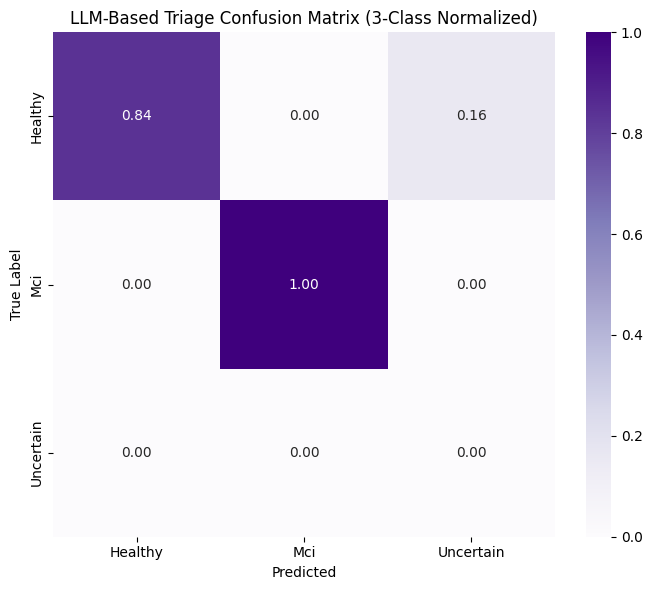

In [13]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

# Load your results file

df = pd.read_csv("llm_subject_predictions_latest_neuropose.csv")

# Normalize labels
df["Subject Condition"] = df["Subject Condition"].str.strip().str.capitalize()
df["LLM Decision"] = df["LLM Decision"].replace("Needs clinical review", "Uncertain").str.strip().str.capitalize()

# Define labels and compute confusion matrix
labels = ["Healthy", "Mci", "Uncertain"]
y_true = df["Subject Condition"]
y_pred = df["LLM Decision"]

# 1. Normalized Confusion Matrix
cm = confusion_matrix(y_true, y_pred, labels=labels, normalize='true')
plt.figure(figsize=(7, 6))
sns.heatmap(cm, annot=True, fmt=".2f", cmap="Purples", xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted")
plt.ylabel("True Label")
plt.title("LLM-Based Triage Confusion Matrix (3-Class Normalized)")
plt.tight_layout()
plt.show()


In [14]:
from sklearn.metrics import accuracy_score

overall_acc = accuracy_score(y_true, y_pred)
print(f"Overall Accuracy: {overall_acc:.2f}")


Overall Accuracy: 0.92


## Classification Report

In [15]:
# 2. Classification Report (Healthy vs MCI only)
binary_report = classification_report(
    y_true, y_pred, labels=["Healthy", "Mci"], output_dict=True, zero_division=0
)
binary_df = pd.DataFrame(binary_report).transpose()
display(binary_df)

,precision,recall,f1-score,support
Healthy,1.0,0.84,0.913043,25.0
Mci,1.0,1.00,1.000000,25.0
micro avg,1.0,0.92,0.958333,50.0
macro avg,1.0,0.92,0.956522,50.0
weighted avg,1.0,0.92,0.956522,50.0


## Decision Distribution Chart

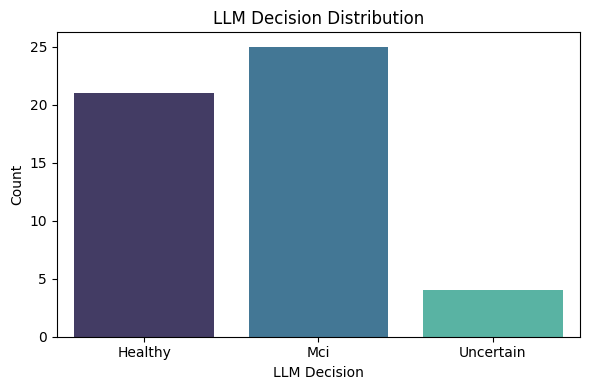

In [ ]:
# 3. Decision Distribution Chart
decision_counts = df["LLM Decision"].value_counts().reindex(labels, fill_value=0)

plt.figure(figsize=(6, 4))
sns.barplot(
    x=decision_counts.index,
    y=decision_counts.values,
    hue=decision_counts.index,
    palette="mako",
    legend=False
)
plt.ylabel("Count")
plt.title("LLM Decision Distribution")
plt.tight_layout()
plt.show()
